In [1]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from math import sin,cos,pi
import scipy 

import seaborn as sns

folder_path = './datas/ohs/'
folder_path2 = './datas/ohss/'
pcanum = 20
tempnum = 200

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 800
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

In [3]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X.toarray())
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

In [4]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
adata_subset = datas[:tempnum,:]
adata_subset
sc.write('./datas/nature/adata_subset.h5',adata_subset)

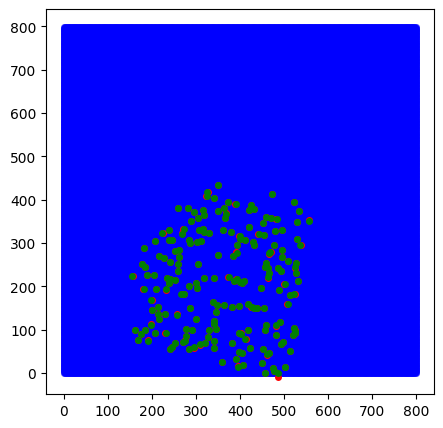

In [5]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")
datas = simulate_gene_exp(datas)
datas,m = simulate_spatial(datas,-pi/12);

count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")
# count_sub.to_csv(folder_path+"datas.data",header=None);
# count_sub.to_csv(folder_path+"datas.csv");

/Users/dongjiajie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5604: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value
/Users/dongjiajie/opt/anaconda3/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


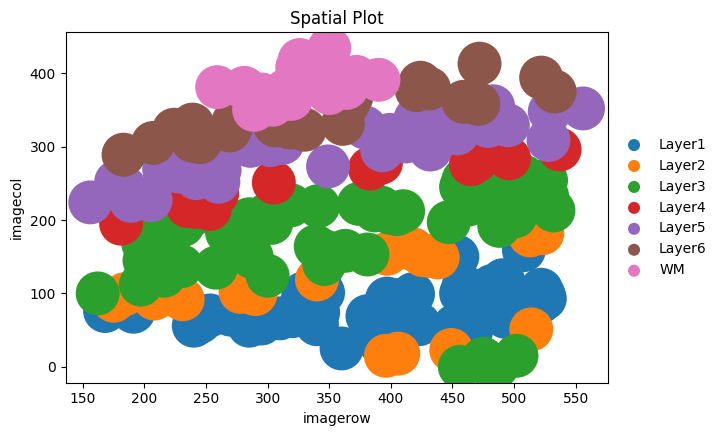

In [6]:
coords = datas.obsm['spatial']
datas.obs.imagerow = coords[:,0]
datas.obs.imagecol = coords[:,1]

sc.pl.scatter(datas,'imagerow', 'imagecol', color='layer_guess_reordered', title='Spatial Plot',size=4000)

In [7]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 9723 by 200

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 200 cells



  |======================================================================| 100%


R[write to console]: Second step: Get residuals using fitted parameters for 9723 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 9723 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 4.013856 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=====                                                                 |   8%
  |                                                                            
  |===========                                                           |  15%
  |                                                                            
  |================                                                      |  23%
  |                                                                         

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  200 
## number of total features:  9723 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  21  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  21  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.253976436196006  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] 

In [8]:
adata1 = pd.read_csv(folder_path + 'pca.csv')
adata1 = adata1.set_index(adata1.columns[0])
adata1 = adata1.T
adata1.index = datas.obs.layer_guess_reordered
adata1.to_csv(folder_path+'datas.data',header=None);
adata1.to_csv(folder_path+'datas.csv')

./datas/ohs/datas.data length:200
Generating all pairs superset


  0%|          | 0/1563 [00:00<?, ?ex/s]

100%|██████████| 1563/1563 [01:05<00:00, 23.84ex/s, loss=0.873810] 


	 Epoch 0 | average train loss: 0.894071
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.90ex/s, loss=0.978856] 


	 Epoch 1 | average train loss: 0.823918
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.72ex/s, loss=0.867760] 


	 Epoch 2 | average train loss: 0.822796
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.91ex/s, loss=0.989529] 


	 Epoch 3 | average train loss: 0.819202
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.17ex/s, loss=0.864089] 


	 Epoch 4 | average train loss: 0.819308
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.11ex/s, loss=0.849488] 


	 Epoch 5 | average train loss: 0.818920
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.88ex/s, loss=0.692520] 


	 Epoch 6 | average train loss: 0.817309
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.19ex/s, loss=0.905821] 


	 Epoch 7 | average train loss: 0.817419
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.07ex/s, loss=0.739945] 


	 Epoch 8 | average train loss: 0.817405
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.18ex/s, loss=0.708180] 


	 Epoch 9 | average train loss: 0.817236
Optimization finished.


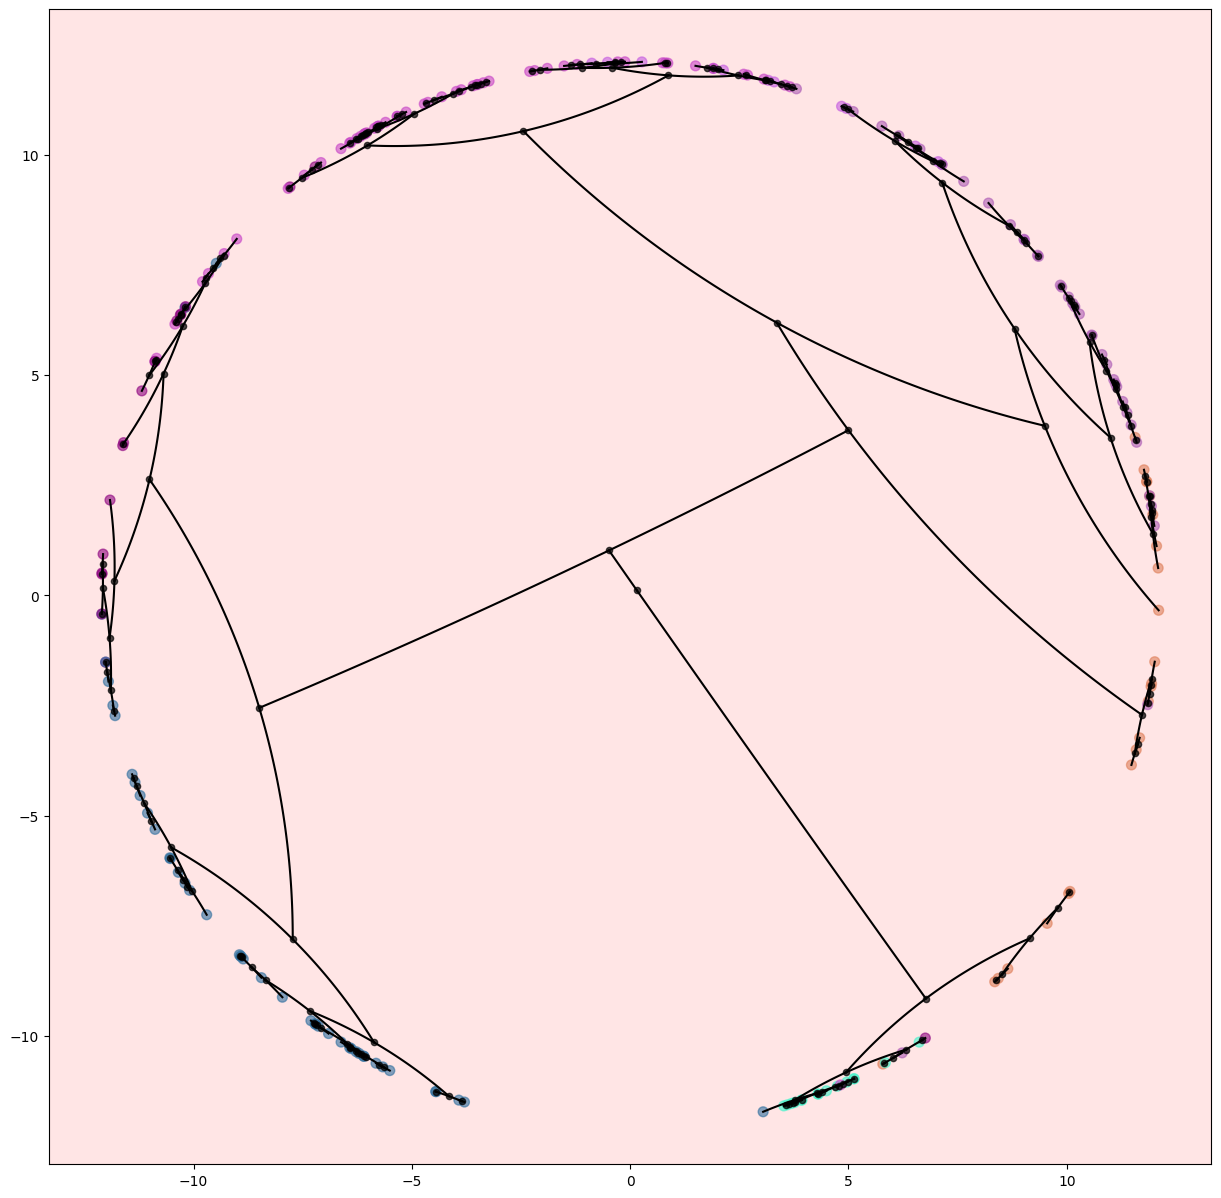

In [10]:
get_Hyper_tree(folder_path+'datas.data',1,adata1.shape[1]+1,0,10,model_path=None,save_path=folder_path,c=-1)


In [11]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")

count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path2+"xy.csv")
datas.obs.to_csv(folder_path2+'meta_data.csv');
count_sub.T.to_csv(folder_path2+"gene.csv")
# count_sub.to_csv(folder_path2+"datas.data",header=None);
# count_sub.to_csv(folder_path2+"datas.csv");


In [12]:
sc.pl.scatter?

Signature:
sc.pl.scatter(
    adata: anndata._core.anndata.AnnData,
    x: Union[str, NoneType] = None,
    y: Union[str, NoneType] = None,
    color: Union[str, Collection[str]] = None,
    use_raw: Union[bool, NoneType] = None,
    layers: Union[str, Collection[str]] = None,
    sort_order: bool = True,
    alpha: Union[float, NoneType] = None,
    basis: Union[Literal['pca', 'tsne', 'umap', 'diffmap', 'draw_graph_fr'], NoneType] = None,
    groups: Union[str, Iterable[str]] = None,
    components: Union[str, Collection[str]] = None,
    projection: Literal['2d', '3d'] = '2d',
    legend_loc: str = 'right margin',
    legend_fontsize: Union[int, float, Literal['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'], NoneType] = None,
    legend_fontweight: Union[int, Literal['light', 'normal', 'medium', 'semibold', 'bold', 'heavy', 'black'], NoneType] = None,
    legend_fontoutline: float = None,
    color_map: Union[str, matplotlib.colors.Colormap] = None,
    pale

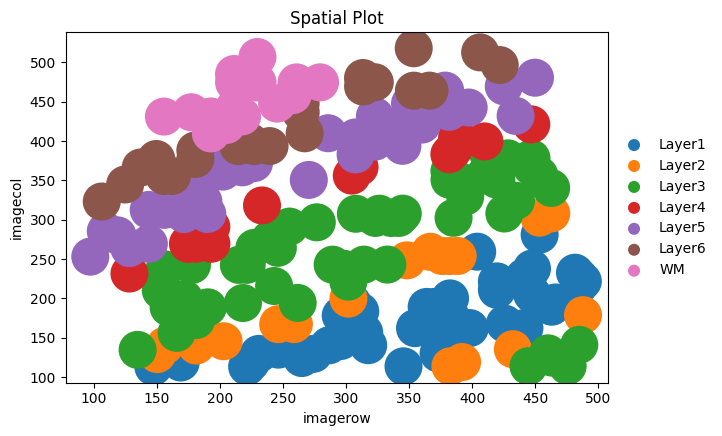

In [13]:
coords = datas.obsm['spatial']
datas.obs.imagerow = coords[:,0]
datas.obs.imagecol = coords[:,1]

sc.pl.scatter(datas,'imagerow', 'imagecol', color='layer_guess_reordered', title='Spatial Plot',size=3000)

In [14]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path2 + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path2 + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path2 + "pca.csv"))

## Use SCTransform function in Seurat to normalize data. 


  |======================================================================| 100%


  |======================================================================| 100%


  |======================================================================| 100%







  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |====================                                                  |  29%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |========================================                              |  57%
  |                                                                            
  |==================================================                    |  71%
  |                                

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  200 
## number of total features:  4547 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  27  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  27  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.292332161645348  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] 

In [15]:
adata2 = pd.read_csv(folder_path2 + 'pca.csv')
adata2 = adata2.set_index(adata2.columns[0])
adata2 = adata2.T
adata2.index = datas.obs.layer_guess_reordered

adata2.to_csv(folder_path2+'datas.data',header=None);
adata2.to_csv(folder_path2+'datas.csv')

./datas/ohss/datas.data length:200
Generating all pairs superset


100%|██████████| 1563/1563 [01:01<00:00, 25.29ex/s, loss=0.974849] 


	 Epoch 0 | average train loss: 0.868402
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.36ex/s, loss=0.988336] 


	 Epoch 1 | average train loss: 0.813120
Optimization finished.


100%|██████████| 1563/1563 [01:04<00:00, 24.17ex/s, loss=0.791284] 


	 Epoch 2 | average train loss: 0.811946
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.95ex/s, loss=0.922073] 


	 Epoch 3 | average train loss: 0.811281
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.84ex/s, loss=0.827796] 


	 Epoch 4 | average train loss: 0.810943
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.75ex/s, loss=0.779026] 


	 Epoch 5 | average train loss: 0.810976
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.93ex/s, loss=0.727094] 


	 Epoch 6 | average train loss: 0.811028
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.98ex/s, loss=0.750082] 


	 Epoch 7 | average train loss: 0.806715
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.88ex/s, loss=0.795802] 


	 Epoch 8 | average train loss: 0.806396
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 26.03ex/s, loss=0.698785] 


	 Epoch 9 | average train loss: 0.806755
Optimization finished.


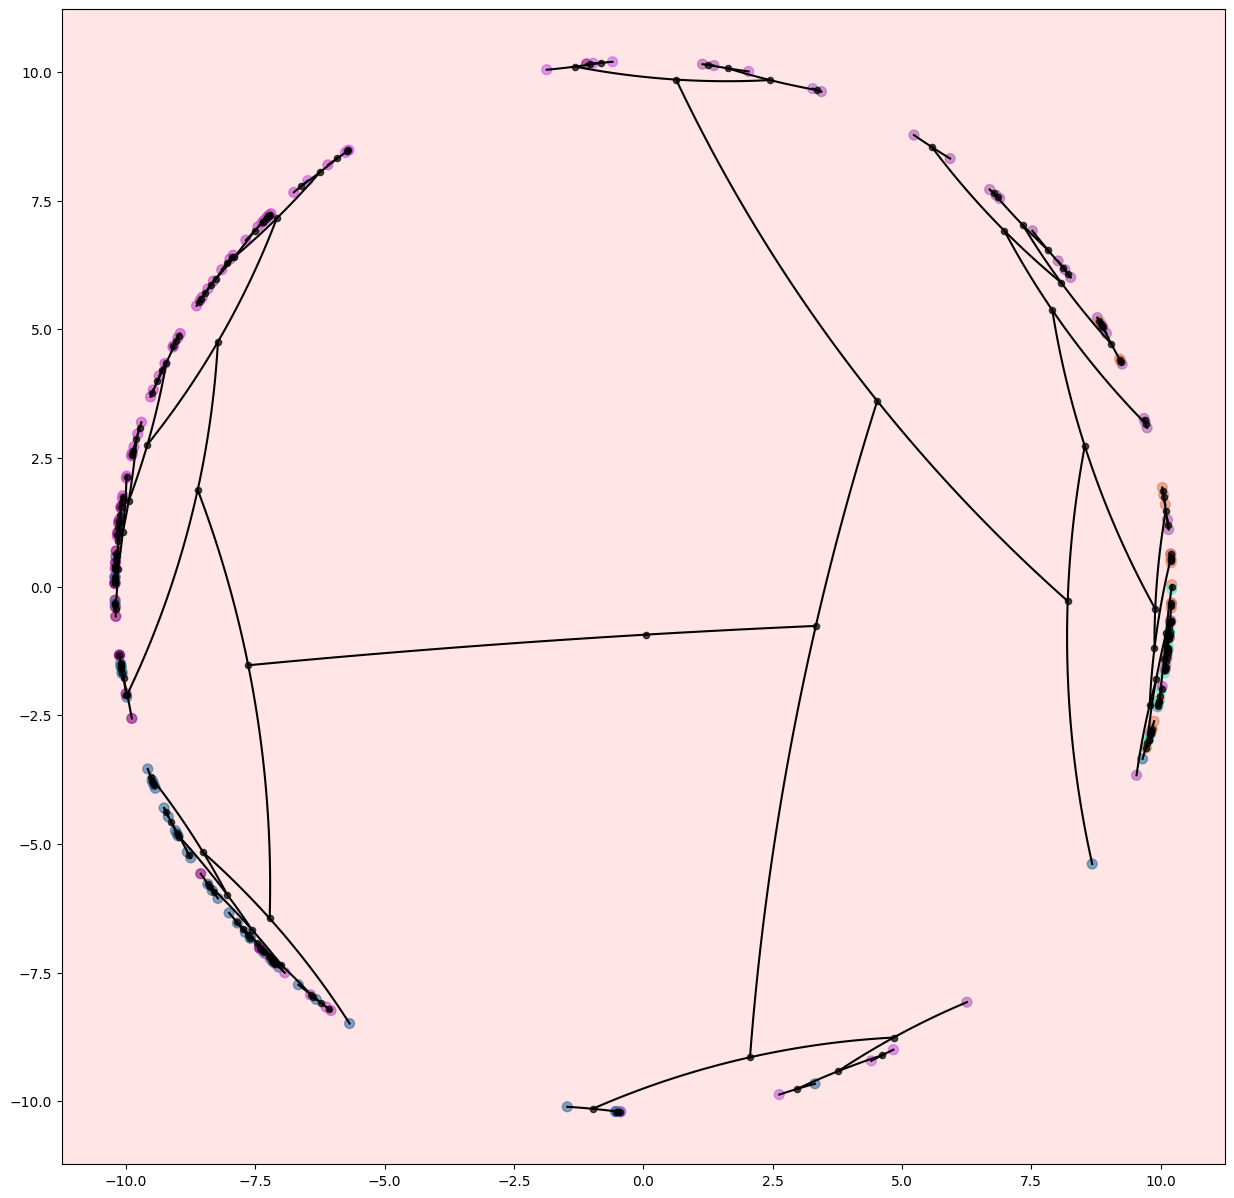

In [16]:
get_Hyper_tree(folder_path2+'datas.data',1,adata2.shape[1]+1,0,10,model_path=None,save_path=folder_path2,c=-1)


In [17]:
nodes2,n2 = build_hyper_tree(folder_path2)
show_tree(nodes2[0]).show_fig()

In [18]:
nodes1,n1 = build_hyper_tree(folder_path)
# show_tree(nodes1[0]).show_fig()
nodes2,n2 = build_hyper_tree(folder_path2)
# show_tree(nodes2[0]).show_fig()
T=tree_alignment(nodes1[0],nodes2[0],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()
G=show_graph(ans,nodes1[0],nodes2[0]);
# G.show_fig()
print("average cost for one node:{}".format(minn/(n1+n2)))

The mininum cost for alignment is 516.4751879699248
The alignment edges list is [('398', '398'), ('395', '387'), ('390', '376'), ('374', '362'), ('370', '353'), ('332', '293'), ('313', '240'), ('288', '239'), ('174', '40'), ('112', '169'), ('85', '55'), ('217', '247'), ('95', '94'), ('53', '34'), ('136', '68'), ('343', '344'), ('339', '297'), ('130', '161'), ('2', '144'), ('323', '341'), ('289', '284'), ('65', '58'), ('19', '173'), ('131', '164'), ('388', '373'), ('381', '364'), ('369', '339'), ('178', '86'), ('239', '295'), ('227', '241'), ('215', '221'), ('138', '91'), ('66', '33'), ('155', '47'), ('158', '139'), ('328', '354'), ('322', '345'), ('299', '303'), ('264', '291'), ('241', '288'), ('92', '19'), ('42', '64'), ('211', '231'), ('122', '8'), ('114', '129'), ('229', '232'), ('104', '2'), ('24', '38'), ('286', '331'), ('163', '93'), ('283', '313'), ('188', '166'), ('96', '235'), ('311', '318'), ('263', '259'), ('214', '256'), ('137', '131'), ('60', '74'), ('51', '128'), ('100', 

In [24]:
datas = sc.read_h5ad('./datas/nature/adata_subset.h5')
datas.obs.layer_guess_reordered

'Layer1'

In [32]:
all = 200;
count =0;
for i,j in ans:
    i = int(i);
    j = int(j);
    if(i<200 and j<200):
        # all+=1
        if(datas.obs.layer_guess_reordered[i] == datas.obs.layer_guess_reordered[j]):
            count+=1;
print(count/all)

0.095


In [31]:
count

19